In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import random
import scipy
from scipy import optimize
from scipy import linalg

import lies
lies.so3exp([1,2,3])

array([[-0.69492056,  0.71352099,  0.08929286],
       [-0.19200697, -0.30378504,  0.93319235],
       [ 0.69297817,  0.6313497 ,  0.34810748]])

In [2]:
img0 = 'k0.jpg'
img1 = 'k1.jpg'
img2 = 'k2.jpg'

trans01 = np.array([0.15, 0, 0, 0, 0, 0])
f = 3000

In [26]:
def imgval(I, p):
    h,w = I.shape
    x = int(p[0] / p[2])
    y = int(p[1] / p[2])
    if x < 0 or x >= w or y < 0 or y >= h:
        return math.nan
    return I[y,x]

def slamResiduals(Ii, Ij, p, xi, Ki, Kj):
    four, k = p.shape
    r = 0
    xim = lies.so3exp(xi[3:])
    pi = Ki @ p
    pj = Kj @ (xim @ p + xi[:3, np.newaxis])
    bad = 0

    for i in range(k):
        ri = imgval(Ii, pi[:, i]) - imgval(Ij, pj[:, i])
        if math.isnan(ri):
            bad += 1
        else:
            r += ri * ri
    if bad > k/2:
        return math.inf

    print("bad: ", bad, "/", k)

    return r / (k - bad)

def slamResidualMatches(p, xi, Kj, ref):
    xim = lies.so3exp(xi)
    pj = Kj @ (xim @ p + xi[:3, np.newaxis])
    pjn = pj[:1,:] / pj[2,:]
    
    return np.linalg.norm(pjn - ref)
    


In [4]:
px0 = cv.imread(img0, 0)
px1 = cv.imread(img1, 0)
px2 = cv.imread(img2, 0)

In [5]:
w, h = px0.shape

In [6]:
lowe = 0.6

sift = cv.xfeatures2d.SIFT_create()
kp0, des0 = sift.detectAndCompute(px0, None)
kp1, des1 = sift.detectAndCompute(px1, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)

good = []
pts1 = []
pts0 = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < lowe * n.distance:
        good.append(m)
        pts1.append(kp1[m.trainIdx].pt)
        pts0.append(kp0[m.queryIdx].pt)



B = np.linalg.norm(trans01)
pts0 = np.array(pts0)
pts1 = np.array(pts1)
disp = np.linalg.norm(pts1 - pts0, axis=1)
depth = B * f / disp
p = np.array([(pts0[:,0] - w/2) * depth, (pts0[:,1] - h/2) * depth, depth, np.ones(depth.shape)])

187
(3264, 1840)
(56, 1064) (378, 837) 394.1276506666196 1.1417620642420774
(116, 2442) (237, 1616) 834.9244421082523 0.5389709263555793
(120, 2439) (237, 1616) 830.9964266977757 0.5415185740186823
(129, 2431) (237, 1616) 821.9727800747933 0.5474633843216237
(149, 2353) (143, 2784) 430.22428248637357 1.045966065419036
(153, 284) (378, 837) 597.8519492726065 0.7526947107013789
(169, 1348) (300, 1788) 459.6389674570644 0.9790292639669095
(178, 371) (404, 912) 586.2151875280842 0.7676362018144429
(187, 1336) (314, 1776) 457.9866859615387 0.9825613141028965
(187, 1336) (314, 1776) 457.9866859615387 0.9825613141028965
(198, 551) (417, 1068) 561.3750758212572 0.8016030981455272
(246, 1397) (368, 1829) 449.2754945161484 1.001612608505683
(275, 2611) (243, 3051) 440.8290763498474 1.0208038084195572
(283, 2761) (237, 1616) 1146.0192151860767 0.3926635732080063
(283, 2761) (237, 1616) 1146.0192151860767 0.3926635732080063
(284, 2778) (237, 1616) 1162.33449918913 0.38715189157159996
(289, 2824) (

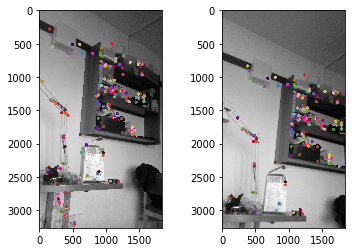

In [7]:
#print (pts0[:15,], pts1[:15,], disp[:15], depth[:15])
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
for i in range(nn):
    colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = i#random.randint(0, nn-1)
    print(tuple(pts0[j,:].astype(int).tolist()), tuple(pts1[j,:].astype(int).tolist()), disp[j], depth[j])
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(121),plt.imshow(px0p)
plt.subplot(122),plt.imshow(px1p)
plt.show()

In [8]:
xi0 = np.array([.0,.00,0.0,0.0,0.0,0.0])

xi = scipy.optimize.fmin(lambda xi: slamResiduals(px0, px2, p, xi), xi0)
#xi = slam.slamStepIterate(px0, px2, p, xi0, 100)

print(xi)

TypeError: slamResiduals() missing 2 required positional arguments: 'Ki' and 'Kj'

In [10]:
pts0 = np.int32(pts0)
pts1 = np.int32(pts1)
F, mask = cv.findFundamentalMat(pts1,pts0,cv.FM_LMEDS)
# We select only inlier points
pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]

107
(3264, 1840)


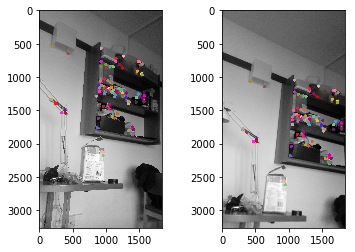

In [11]:
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
for i in range(nn):
    colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = i#random.randint(0, nn-1)
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(121),plt.imshow(px0p)
plt.subplot(122),plt.imshow(px1p)
plt.show()

In [12]:
lowe = 0.8

sift = cv.xfeatures2d.SIFT_create()
kp0, des0 = sift.detectAndCompute(px0, None)
kp1, des1 = sift.detectAndCompute(px1, None)
kp2, des2 = sift.detectAndCompute(px2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches01 = flann.knnMatch(des1, des0, k=2)
matches02 = flann.knnMatch(des2, des0, k=2)

good01 = {}

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches01):
    if m.distance < lowe * n.distance:
        good01[m.trainIdx] = m
        
pts0 = []
pts1 = []
pts2 = []
        
for i, (m, n) in enumerate(matches02):
    if m.distance < lowe * n.distance:
        if m.trainIdx in good01:
            pts0.append(kp0[m.trainIdx].pt)
            pts1.append(kp1[good01[m.trainIdx].queryIdx].pt)
            pts2.append(kp2[m.queryIdx].pt)
        
pts0 = np.int32(pts0)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

print(pts0.shape)

(46, 2)


In [13]:
# we should already know this matrix?
F01, mask = cv.findFundamentalMat(pts1,pts0,cv.FM_LMEDS)
# We select only inlier points
pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


F02, mask = cv.findFundamentalMat(pts2,pts0,cv.FM_LMEDS)
pts0 = pts0[mask.ravel()==1]
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


24
(3264, 1840)


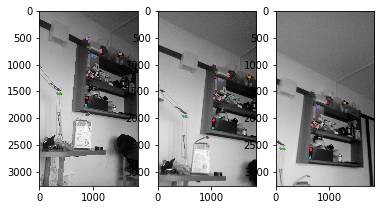

In [14]:
nn,two = pts0.shape
print(nn)
print(px0.shape)

px0p = cv.cvtColor(px0, cv.COLOR_GRAY2BGR)
px1p = cv.cvtColor(px1, cv.COLOR_GRAY2BGR)
px2p = cv.cvtColor(px2, cv.COLOR_GRAY2BGR)
for i in range(nn):
    colour = (random.randint(60, 256), random.randint(0, 200), random.randint(20, 200))
    j = i#random.randint(0, nn-1)
    px0p = cv.circle(px0p, tuple(pts0[j,:].astype(int).tolist()), 24, colour, -1)
    px1p = cv.circle(px1p, tuple(pts1[j,:].astype(int).tolist()), 24, colour, -1)
    px2p = cv.circle(px2p, tuple(pts2[j,:].astype(int).tolist()), 24, colour, -1)
    
plt.subplot(131),plt.imshow(px0p)
plt.subplot(132),plt.imshow(px1p)
plt.subplot(133),plt.imshow(px2p)
plt.show()

In [15]:
# TODO calibrate camera
K0 = np.array([[3000, 0, 920], [0, 3000, 1632], [0, 0, 1]])
K1 = np.array([[3000, 0, 920], [0, 3000, 1632], [0, 0, 1]])

# calculate essential matrix
E = K0.transpose() @ F02 @ K0
print(E)

[[ 1.10669896  7.31912421  1.17305861]
 [-6.03640527 -0.07748482 -0.32176681]
 [-3.21781377 -0.17365586 -0.19170825]]


In [28]:
# get null space of essential matrix
U,s,Vt = scipy.linalg.svd(E)
nullmask = (s <= 1e-7)
t = scipy.compress(nullmask, Vt, axis=0)[0]

# finding rotation matrix
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
Wt = W.transpose()

Ra = U @ Wt @ Vt
Rb = U @ W @ Vt
rota = lies.so3log(Ra)
rotb = lies.so3log(Rb)

print(t)
print (np.linalg.det(Ra))
print (rota)

[-0.05069454 -0.15057202  0.9872984 ]
0.9999999999999999
[0.06908452 0.97110528 2.92738872]


In [29]:
k, two = pts0.shape
disp = np.linalg.norm(pts1 - pts0, axis=1)
depth = B * f / disp
L = np.linalg.inv(K0) # require square camera matrix (so without the fourth all zero column), that will return 1 on the z coordinate
p = L @ np.array([pts0[:,0], pts0[:,1], np.ones((k))]) * depth

ref = pts2.transpose()

# doesn't work, probably slamResiduals is bad
#s = scipy.optimize.fmin(lambda l: slamResiduals(px0, px2, p, np.concatenate([t * l[0], rota]), K0, K0), [0.0])

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([t * l[0], rota]), K0, ref), [0.0])

print(s)

s = scipy.optimize.fmin(lambda l: slamResidualMatches(p, np.concatenate([t * l[0], rotb]), K0, ref), [0.0])

print(s)

Optimization terminated successfully.
         Current function value: 5584.081924
         Iterations: 20
         Function evaluations: 40
[-0.19325]
Optimization terminated successfully.
         Current function value: 5501.024922
         Iterations: 21
         Function evaluations: 42
[-0.32475]
